In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Converting 2021 BRFSS Dataframe Columns to appropriate datatype

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [13]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [14]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [15]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# 2019 indexed with common columns
brfss_df = modeldf2019[common_columns]


In [16]:
#Lets clean up 2019 dataset and keep as training datset

In [17]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [18]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  210771 non-null  category
 1    STATERE1  71738 non-null   category
 2    LADULT1   71738 non-null   category
 3    COLGSEX   21 non-null      category
 4    LANDSEX   30365 non-null   category
 5    RESPSLCT  36285 non-null   category
 6    SAFETIME  139033 non-null  category
 7    CADULT1   139033 non-null  category
 8    CELLSEX   139026 non-null  category
 9    HHADULT   139028 non-null  float64 
 10   SEXVAR    210771 non-null  category
 11   GENHLTH   210753 non-null  category
 12   PHYSHLTH  210750 non-null  category
 13   MENTHLTH  210761 non-null  category
 14   POORHLTH  116171 non-null  float64 
 15   PRIMINSR  210764 non-null  category
 16   MEDCOST1  210765 non-null  category
 17   CHECKUP1  210763 non-null  category
 18   BPMEDS    81278 non-null   category
 19   

In [19]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [20]:
#list(processed_features_df['STATE'].unique())

### Generate EDA Report with Original Dataset

In [21]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

### Handle Missing data

In [22]:
pd.reset_option('display.max_rows',None)

In [23]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   210750  0.999900
NUMPHON3  192684  0.914186
CAGEG     185674  0.880928
DIABAGE3  183766  0.871875
ASTHNOW   180692  0.857291
LANDSEX   180406  0.855934
RESPSLCT  174486  0.827846
PREGNANT  171430  0.813347
ARTHDIS2  144913  0.687538
LMTJOIN3  144911  0.687528
ARTHEDU   144910  0.687523
JOINPAI2  144910  0.687523
ARTHEXER  144909  0.687519
HIVTSTD3  142395  0.675591
NUMHHOL3  139607  0.662363
STATERE1  139033  0.659640
LADULT1   139033  0.659640
_FLSHOT7  134644  0.638817
_PNEUMO3  134644  0.638817
SMOKDAY2  130371  0.618543
BPMEDS    129493  0.614378
FLSHTMY3  113726  0.539571
MAXDRNKS  105730  0.501634
DRNK3GE5  105615  0.501089
AVEDRNK3  105247  0.499343
POORHLTH   94600  0.448828
CELLSEX    71745  0.340393
HHADULT    71743  0.340384
CADULT1    71738  0.340360
SAFETIME   71738  0.340360
_VEGESU1   27521  0.130573
_RFCHOL3   23836  0.113090
_FRUTSU1   23119  0.109688
VEGEDA2_   22774  0.108051
POTADA1_   22065  0.104687
HIVTST7    21301  0.101062
_

In [24]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 106 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   139033 non-null  category
 1    HHADULT   139028 non-null  float64 
 2    SEXVAR    210771 non-null  category
 3    GENHLTH   210753 non-null  category
 4    PHYSHLTH  210750 non-null  category
 5    MENTHLTH  210761 non-null  category
 6    POORHLTH  116171 non-null  float64 
 7    PRIMINSR  210764 non-null  category
 8    MEDCOST1  210765 non-null  category
 9    CHECKUP1  210763 non-null  category
 10   CVDINFR4  210763 non-null  category
 11   CVDCRHD4  210764 non-null  category
 12   CVDSTRK3  210762 non-null  category
 13   ASTHMA3   210764 non-null  category
 14   CHCSCNCR  210764 non-null  category
 15   CHCOCNCR  210763 non-null  category
 16   ADDEPEV3  210763 non-null  category
 17   CHCKDNY2  210763 non-null  category
 18   DIABETE4  210764 non-null  category
 19   

##### Vegetable and fruit columns calculated from other veg_fruit columns (So we will keep only these ones)
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


#Drop redundant Columns and irreleveant columns

#REFINE THIS AS SOME COLUMNS MAY BE IMPORTANT FOR PREDICTING _RFHLTH


processed_features_df.drop(columns=['SEQNO','_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7','MMSANAME'],inplace=True)

<Axes: >

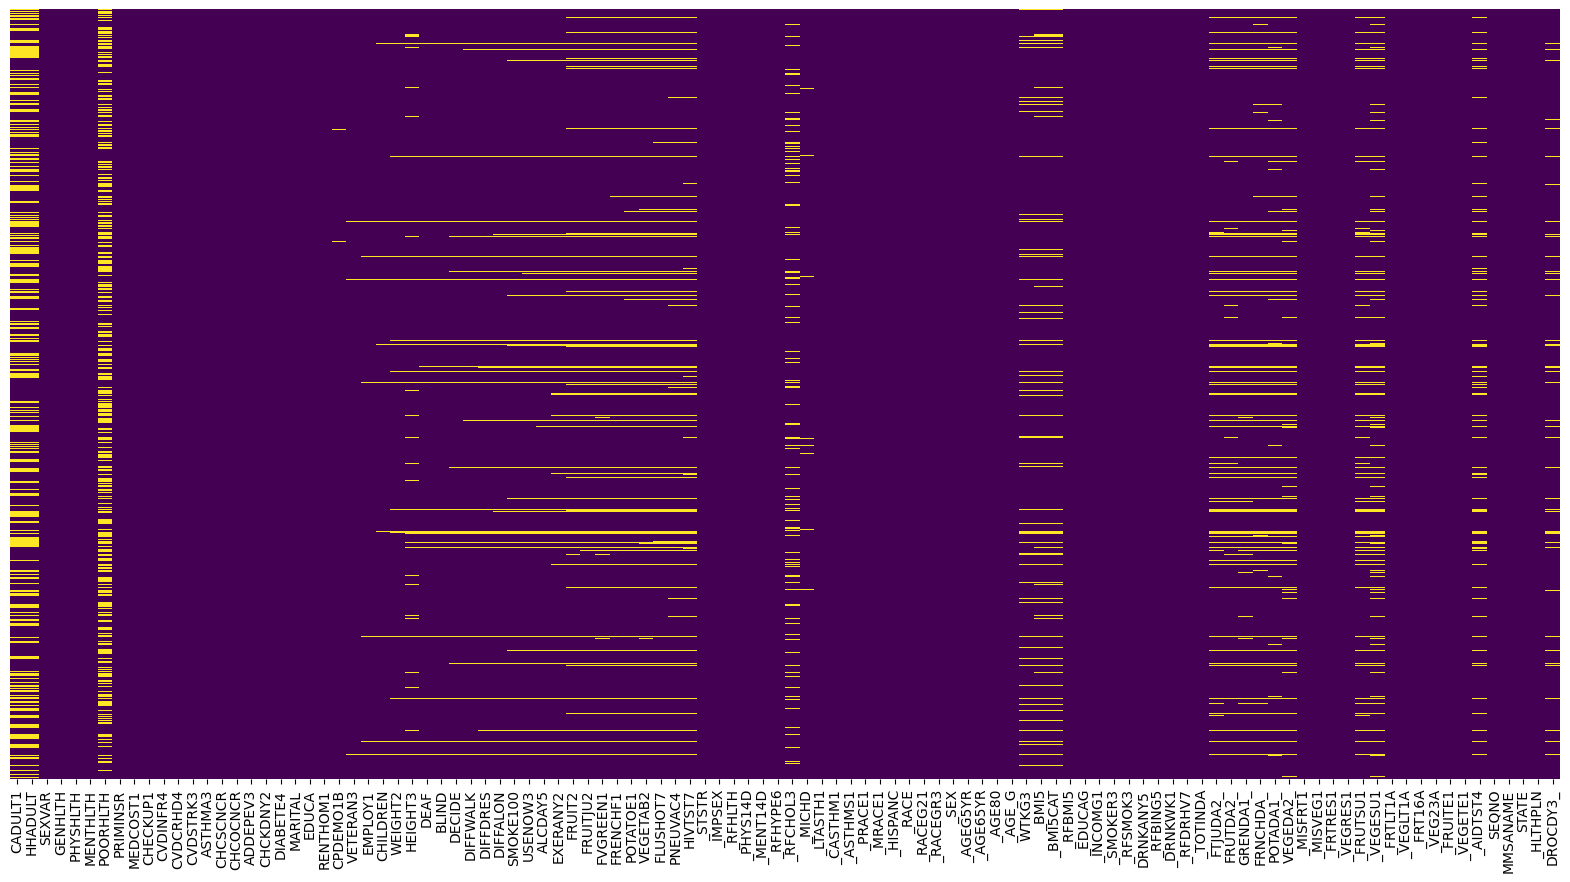

In [25]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [26]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [27]:
print(missing_data.to_string())

          Total   Percent
POORHLTH  94600  0.448828
HHADULT   71743  0.340384
CADULT1   71738  0.340360
_VEGESU1  27521  0.130573
_RFCHOL3  23836  0.113090
_FRUTSU1  23119  0.109688
VEGEDA2_  22774  0.108051
POTADA1_  22065  0.104687
_AIDTST4  21301  0.101062
HIVTST7   21301  0.101062
FRNCHDA_  20400  0.096788
GRENDA1_  20353  0.096565
FRUTDA2_  20305  0.096337
FTJUDA2_  20230  0.095981
PNEUVAC4  19921  0.094515
_BMI5     19446  0.092261
_BMI5CAT  19446  0.092261
VEGETAB2  19317  0.091649
FLUSHOT7  19314  0.091635
POTATOE1  18349  0.087057
FRENCHF1  17832  0.084604
FVGREEN1  17592  0.083465
FRUITJU2  17008  0.080694
FRUIT2    16550  0.078521
WTKG3     15829  0.075100
DROCDY3_  12301  0.058362
HEIGHT3   11321  0.053712
EXERANY2  11194  0.053110
ALCDAY5    9828  0.046629
USENOW3    8944  0.042435
SMOKE100   8552  0.040575
DIFFALON   8007  0.037989
DIFFDRES   7597  0.036044
DIFFWALK   7288  0.034578
DECIDE     6842  0.032462
BLIND      6382  0.030279
DEAF       5965  0.028301
WEIGHT2    4

In [28]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [29]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [30]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [31]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [32]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [33]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [34]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [35]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

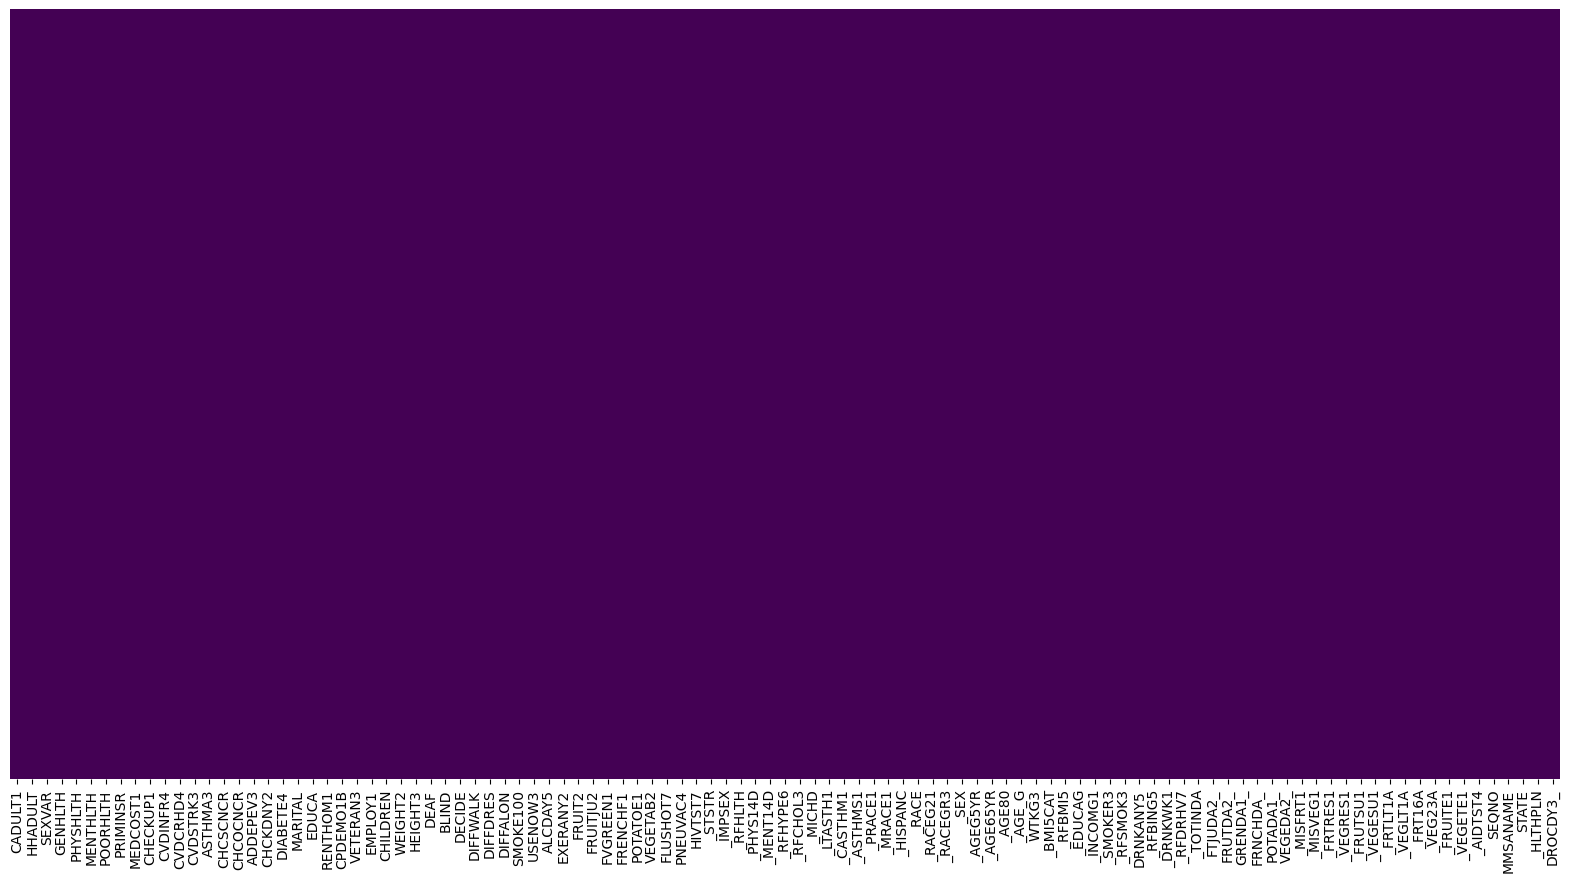

In [36]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [37]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
#profile.to_file(output_file="EDA_Report_Cleaned.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69548 entries, 1 to 210771
Data columns (total 105 columns):
 #    Column    Non-Null Count  Dtype   
---   ------    --------------  -----   
 0    CADULT1   69548 non-null  category
 1    HHADULT   69548 non-null  float64 
 2    SEXVAR    69548 non-null  category
 3    GENHLTH   69548 non-null  category
 4    PHYSHLTH  69548 non-null  category
 5    MENTHLTH  69548 non-null  category
 6    POORHLTH  69548 non-null  float64 
 7    PRIMINSR  69548 non-null  category
 8    MEDCOST1  69548 non-null  category
 9    CHECKUP1  69548 non-null  category
 10   CVDINFR4  69548 non-null  category
 11   CVDCRHD4  69548 non-null  category
 12   CVDSTRK3  69548 non-null  category
 13   ASTHMA3   69548 non-null  category
 14   CHCSCNCR  69548 non-null  category
 15   CHCOCNCR  69548 non-null  category
 16   ADDEPEV3  69548 non-null  category
 17   CHCKDNY2  69548 non-null  category
 18   DIABETE4  69548 non-null  category
 19   MARITAL   69548 non-nu

In [39]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   69548.0  2.670300e+00      6.986128  1.000000e+00  1.000000e+00   
POORHLTH  69548.0  5.292670e+01     39.078614  1.000000e+00  7.000000e+00   
CHILDREN  69548.0  5.902414e+01     40.809026  1.000000e+00  2.000000e+00   
WEIGHT2   69548.0  5.514971e+02   1791.524892  5.100000e+01  1.500000e+02   
HEIGHT3   69548.0  1.703720e+00      0.105330  9.144000e-01  1.625600e+00   
FRUIT2    69548.0  1.947976e+02    128.853688  1.010000e+02  1.020000e+02   
FRUITJU2  69548.0  3.804898e+02    178.973255  1.010000e+02  2.030000e+02   
FVGREEN1  69548.0  2.486477e+02    130.479440  1.010000e+02  2.010000e+02   
FRENCHF1  69548.0  3.016825e+02    130.319606  1.010000e+02  2.020000e+02   
POTATOE1  69548.0  3.116087e+02    138.947606  1.010000e+02  2.020000e+02   
VEGETAB2  69548.0  2.096040e+02    127.782375  1.010000e+02  1.020000e+02   
_STSTR    69548.0  2.452270e+04  15061.334552  1.019000e+03  1.301900e+04   
_AGE80    69548.0  4.660036e+01     17.088726  1.800000e+01  3.200000e+01   
WTKG3     69548.0  8.303351e+01     21.826683  2.313000e+01  6.804000e+01   
_DRNKWK1  69548.0  1.391354e+03  10222.602692  0.000000e+00  0.000000e+00   
FTJUDA2_  69548.0  2.928109e-01      1.135408  0.000000e+00  0.000000e+00   
FRUTDA2_  69548.0  1.080070e+00      1.569626  0.000000e+00  3.300000e-01   
GRENDA1_  69548.0  5.614346e-01      1.150427  0.000000e+00  1.400000e-01   
FRNCHDA_  69548.0  2.396867e-01      0.577739  0.000000e+00  7.000000e-02   
POTADA1_  69548.0  2.244973e-01      0.557542  0.000000e+00  3.000000e-02   
VEGEDA2_  69548.0  9.488702e-01      1.558393  0.000000e+00  4.000000e-01   
_FRUTSU1  69548.0  1.367979e+00      2.017426  0.000000e+00  5.000000e-01   
_VEGESU1  69548.0  1.969399e+00      2.517051  0.000000e+00  1.100000e+00   
SEQNO     69548.0  2.019002e+09   1595.250583  2.019000e+09  2.019001e+09   
DROCDY3_  69548.0  1.662468e-01      0.261944  0.000000e+00  0.000000e+00   

                   50%           75%           99%           max  
HHADULT   2.000000e+00  3.000000e+00  6.000000e+00  9.900000e+01  
POORHLTH  8.800000e+01  8.800000e+01  8.800000e+01  9.900000e+01  
CHILDREN  8.800000e+01  8.800000e+01  9.900000e+01  9.900000e+01  
WEIGHT2   1.800000e+02  2.150000e+02  9.999000e+03  9.999000e+03  
HEIGHT3   1.701800e+00  1.778000e+00  1.930400e+00  2.260600e+00  
FRUIT2    2.010000e+02  2.050000e+02  7.770000e+02  9.990000e+02  
FRUITJU2  3.080000e+02  5.550000e+02  7.770000e+02  9.990000e+02  
FVGREEN1  2.030000e+02  3.040000e+02  5.550000e+02  9.990000e+02  
FRENCHF1  3.010000e+02  3.060000e+02  5.550000e+02  9.990000e+02  
POTATOE1  3.020000e+02  3.080000e+02  7.770000e+02  9.990000e+02  
VEGETAB2  2.030000e+02  3.010000e+02  7.770000e+02  9.990000e+02  
_STSTR    2.403900e+04  3.801900e+04  5.102900e+04  5.210900e+04  
_AGE80    4.700000e+01  6.000000e+01  8.000000e+01  8.000000e+01  
WTKG3     7.938000e+01  9.389000e+01  1.496900e+02  2.766900e+02  
_DRNKWK1  4.700000e+01  3.500000e+02  9.990000e+04  9.990000e+04  
FTJUDA2_  3.000000e-02  2.900000e-01  3.000000e+00  9.000000e+01  
FRUTDA2_  1.000000e+00  1.000000e+00  5.000000e+00  9.200000e+01  
GRENDA1_  4.300000e-01  7.100000e-01  3.000000e+00  9.000000e+01  
FRNCHDA_  1.400000e-01  2.900000e-01  1.430000e+00  5.000000e+01  
POTADA1_  1.400000e-01  2.900000e-01  1.000000e+00  3.200000e+01  
VEGEDA2_  7.100000e-01  1.000000e+00  5.000000e+00  9.000000e+01  
_FRUTSU1  1.000000e+00  2.000000e+00  6.000000e+00  9.600000e+01  
_VEGESU1  1.580000e+00  2.280000e+00  8.170000e+00  1.200000e+02  
SEQNO     2.019001e+09  2.019002e+09  2.019007e+09  2.019008e+09  
DROCDY3_  3.333333e-02  2.000000e-01  1.000000e+00  1.000000e+00

In [40]:
# Replace outliers with the 99 percentile value except weight column

num_cols = ['HEIGHT3','_DRNKWK1','FTJUDA2_','FRUTDA2_','GRENDA1_','FRNCHDA_',
            'POTADA1_','VEGEDA2_','_FRUTSU1','_VEGESU1','DROCDY3_']

for i in num_cols:
    percentile_99 = np.percentile(processed_features_df[i], 99)
    processed_features_df.loc[processed_features_df[i] > percentile_99, i] = percentile_99


In [41]:
processed_features_df['POORHLTH'] = processed_features_df['POORHLTH'].astype('category')

In [42]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   69548.0  2.670300e+00      6.986128  1.000000e+00  1.000000e+00   
CHILDREN  69548.0  5.902414e+01     40.809026  1.000000e+00  2.000000e+00   
WEIGHT2   69548.0  5.514971e+02   1791.524892  5.100000e+01  1.500000e+02   
HEIGHT3   69548.0  1.703279e+00      0.104210  9.144000e-01  1.625600e+00   
FRUIT2    69548.0  1.947976e+02    128.853688  1.010000e+02  1.020000e+02   
FRUITJU2  69548.0  3.804898e+02    178.973255  1.010000e+02  2.030000e+02   
FVGREEN1  69548.0  2.486477e+02    130.479440  1.010000e+02  2.010000e+02   
FRENCHF1  69548.0  3.016825e+02    130.319606  1.010000e+02  2.020000e+02   
POTATOE1  69548.0  3.116087e+02    138.947606  1.010000e+02  2.020000e+02   
VEGETAB2  69548.0  2.096040e+02    127.782375  1.010000e+02  1.020000e+02   
_STSTR    69548.0  2.452270e+04  15061.334552  1.019000e+03  1.301900e+04   
_AGE80    69548.0  4.660036e+01     17.088726  1.800000e+01  3.200000e+01   
WTKG3     69548.0  8.303351e+01     21.826683  2.313000e+01  6.804000e+01   
_DRNKWK1  69548.0  1.391354e+03  10222.602692  0.000000e+00  0.000000e+00   
FTJUDA2_  69548.0  2.580513e-01      0.486287  0.000000e+00  0.000000e+00   
FRUTDA2_  69548.0  1.036456e+00      0.947847  0.000000e+00  3.300000e-01   
GRENDA1_  69548.0  5.170581e-01      0.542096  0.000000e+00  1.400000e-01   
FRNCHDA_  69548.0  2.176248e-01      0.254038  0.000000e+00  7.000000e-02   
POTADA1_  69548.0  1.992629e-01      0.223884  0.000000e+00  3.000000e-02   
VEGEDA2_  69548.0  8.915347e-01      0.811853  0.000000e+00  4.000000e-01   
_FRUTSU1  69548.0  1.298852e+00      1.131142  0.000000e+00  5.000000e-01   
_VEGESU1  69548.0  1.867668e+00      1.306646  0.000000e+00  1.100000e+00   
SEQNO     69548.0  2.019002e+09   1595.250583  2.019000e+09  2.019001e+09   
DROCDY3_  69548.0  1.662468e-01      0.261944  0.000000e+00  0.000000e+00   

                   50%           75%           99%           max  
HHADULT   2.000000e+00  3.000000e+00  6.000000e+00  9.900000e+01  
CHILDREN  8.800000e+01  8.800000e+01  9.900000e+01  9.900000e+01  
WEIGHT2   1.800000e+02  2.150000e+02  9.999000e+03  9.999000e+03  
HEIGHT3   1.701800e+00  1.778000e+00  1.930400e+00  1.930400e+00  
FRUIT2    2.010000e+02  2.050000e+02  7.770000e+02  9.990000e+02  
FRUITJU2  3.080000e+02  5.550000e+02  7.770000e+02  9.990000e+02  
FVGREEN1  2.030000e+02  3.040000e+02  5.550000e+02  9.990000e+02  
FRENCHF1  3.010000e+02  3.060000e+02  5.550000e+02  9.990000e+02  
POTATOE1  3.020000e+02  3.080000e+02  7.770000e+02  9.990000e+02  
VEGETAB2  2.030000e+02  3.010000e+02  7.770000e+02  9.990000e+02  
_STSTR    2.403900e+04  3.801900e+04  5.102900e+04  5.210900e+04  
_AGE80    4.700000e+01  6.000000e+01  8.000000e+01  8.000000e+01  
WTKG3     7.938000e+01  9.389000e+01  1.496900e+02  2.766900e+02  
_DRNKWK1  4.700000e+01  3.500000e+02  9.990000e+04  9.990000e+04  
FTJUDA2_  3.000000e-02  2.900000e-01  3.000000e+00  3.000000e+00  
FRUTDA2_  1.000000e+00  1.000000e+00  5.000000e+00  5.000000e+00  
GRENDA1_  4.300000e-01  7.100000e-01  3.000000e+00  3.000000e+00  
FRNCHDA_  1.400000e-01  2.900000e-01  1.430000e+00  1.430000e+00  
POTADA1_  1.400000e-01  2.900000e-01  1.000000e+00  1.000000e+00  
VEGEDA2_  7.100000e-01  1.000000e+00  5.000000e+00  5.000000e+00  
_FRUTSU1  1.000000e+00  2.000000e+00  6.000000e+00  6.000000e+00  
_VEGESU1  1.580000e+00  2.280000e+00  8.170000e+00  8.170000e+00  
SEQNO     2.019001e+09  2.019002e+09  2.019007e+09  2.019008e+09  
DROCDY3_  3.333333e-02  2.000000e-01  1.000000e+00  1.000000e+00

- We can see the presence of significant multicolinearity between the fruits and vegetable columns, which we will
look to remove further down the line 

#### Export the processed df out to be split into training and validation data

In [43]:
processed_features_df.to_csv('mydata/MMSA2019_Cleaned.csv', index=False)

### EXPLORATORY DATA ANALYSIS

<Axes: >

<Figure size 1200x800 with 0 Axes>

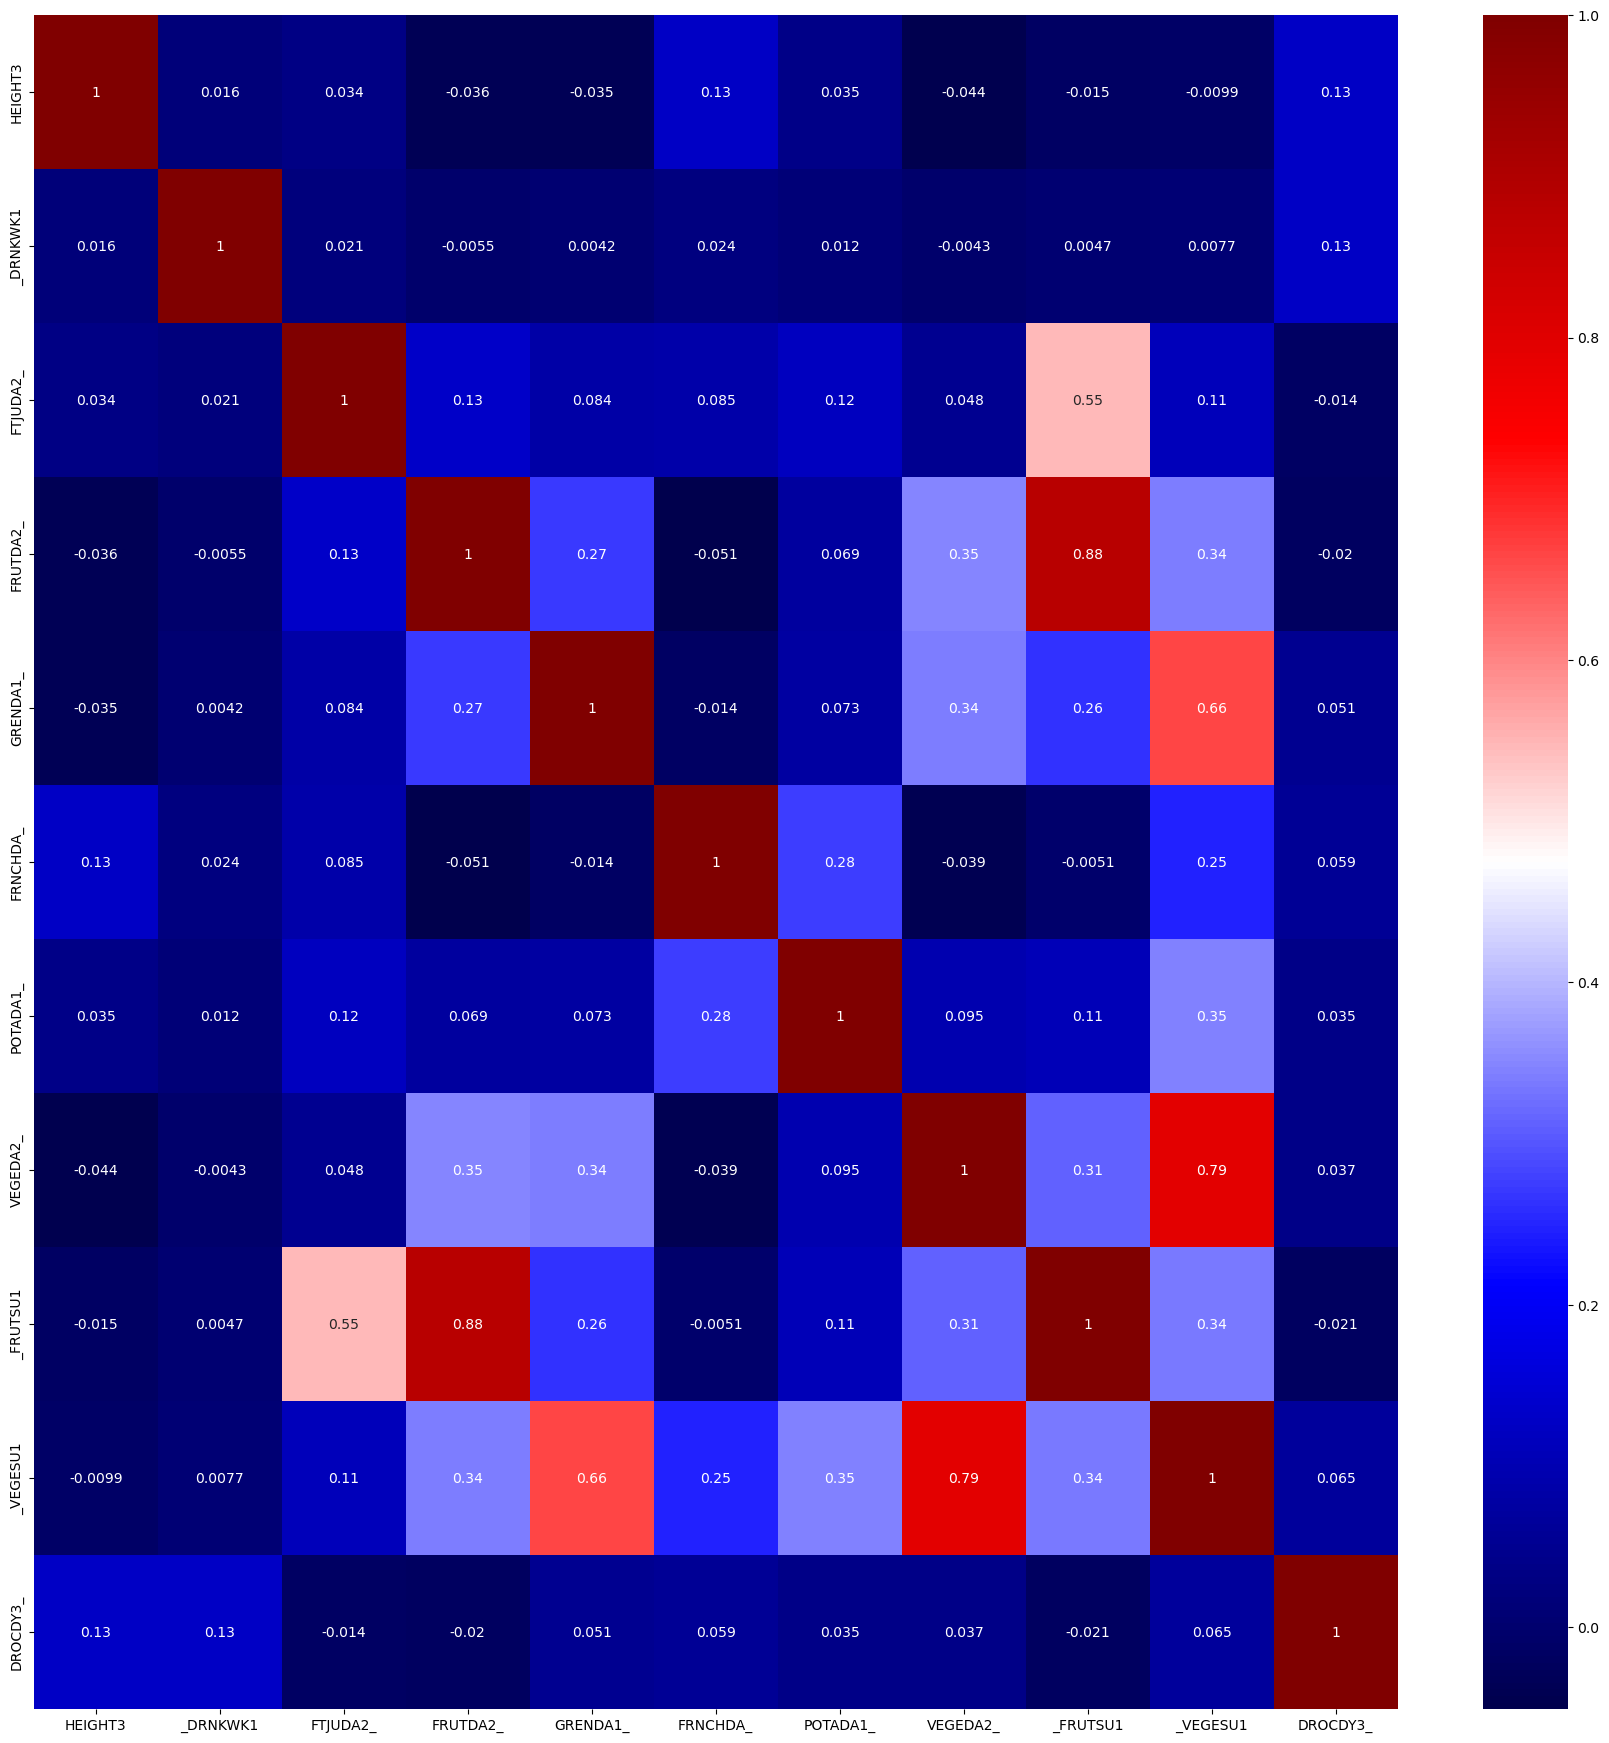

In [44]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='seismic',annot=True)

In [45]:
num_cols = processed_features_df.select_dtypes(include=('float','int')).columns
cat_cols = processed_features_df.select_dtypes(exclude=('float','int')).columns

In [46]:
cat_cols 

Index(['CADULT1', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH',
       'PRIMINSR', 'MEDCOST1', 'CHECKUP1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3',
       'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4',
       'MARITAL', 'EDUCA', 'RENTHOM1', 'CPDEMO1B', 'VETERAN3', 'EMPLOY1',
       'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON',
       'SMOKE100', 'USENOW3', 'ALCDAY5', 'EXERANY2', 'FLUSHOT7', 'PNEUVAC4',
       'HIVTST7', '_IMPSEX', '_RFHLTH', '_PHYS14D', '_MENT14D', '_RFHYPE6',
       '_RFCHOL3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1', '_PRACE1',
       '_MRACE1', '_HISPANC', '_RACE', '_RACEG21', '_RACEGR3', '_SEX',
       '_AGEG5YR', '_AGE65YR', '_AGE_G', '_BMI5CAT', '_RFBMI5', '_EDUCAG',
       '_INCOMG1', '_SMOKER3', '_RFSMOK3', 'DRNKANY5', '_RFBING5', '_RFDRHV7',
       '_TOTINDA', '_MISFRT1', '_MISVEG1', '_FRTRES1', '_VEGRES1', '_FRTLT1A',
       '_VEGLT1A', '_FRT16A', '_VEG23A', '_FRUITE1', '_VEGETE1', '_AIDTST4',
       'MMSANA

In [47]:
#here we want to print out the value count in eah categorical column

# normalize used to get the percentage 
for i in list(cat_cols):
    print(processed_features_df[i].value_counts(normalize=True))
    print('**********************************')

1.0    1.0
Name: CADULT1, dtype: float64
**********************************
2    0.548384
1    0.451616
Name: SEXVAR, dtype: float64
**********************************
3.0    0.325027
2.0    0.307658
4.0    0.182608
1.0    0.117588
5.0    0.064948
7.0    0.001610
9.0    0.000561
Name: GENHLTH, dtype: float64
**********************************
88.0    0.321706
30.0    0.114942
2.0     0.109593
1.0     0.086933
3.0     0.066041
5.0     0.053186
10.0    0.036823
7.0     0.034077
4.0     0.032194
15.0    0.030770
77.0    0.028412
20.0    0.020231
14.0    0.016780
6.0     0.008814
25.0    0.008052
8.0     0.005866
21.0    0.004544
99.0    0.004285
12.0    0.003609
28.0    0.002833
9.0     0.001625
18.0    0.001265
29.0    0.001222
16.0    0.001078
27.0    0.000935
17.0    0.000733
22.0    0.000661
13.0    0.000647
26.0    0.000546
11.0    0.000546
23.0    0.000474
24.0    0.000374
19.0    0.000201
Name: PHYSHLTH, dtype: float64
**********************************
88.0    0.290044
30.0    0.1

## REPLACE NUMERIC CATEGORICAL COLUMNS WITH ACTUAL CATEGORIES FROM QUESTIONNAIRE 


income = df['income2']
race = df['x.race']
state = df['x.state']
age = df['x.ageg5yr']
sex = df['sex']
height = df['height3']
weight = df['weight2']

income_replace = {1:'<10k', 2:'10k-15k', 3:'15k-20k', 4:'20k-25k', 5:'25k-35k', 6:'35k-50k', 7:'>50k', 8:'>50k', 77:np.nan, 99:np.nan}
race_replace = {1:'white', 2:'black', 3:'native american', 4:'asian/pacific islander', 5:'asian/pacific islander', 6:'other/multiracial', 7:'other/multiracial', 8:'hispanic', 9:'refused/unknown'}
age_replace = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 10:'65-69', 11:'70-74', 12:'75-79', 13:'80+', 14:np.nan}
sex_replace = {1:'male', 2:'female'}
hw_replace = {7777:np.nan, 9999:np.nan}
metric = True
max_weight = 999

income = income.replace(income_replace)
race = race.replace(race_replace)
age = age.replace(age_replace)
sex = sex.replace(sex_replace)
height = height.replace(hw_replace)
weight = weight.replace(hw_replace)

In [49]:
num_cols

Index(['HHADULT', 'CHILDREN', 'WEIGHT2', 'HEIGHT3', 'FRUIT2', 'FRUITJU2',
       'FVGREEN1', 'FRENCHF1', 'POTATOE1', 'VEGETAB2', '_STSTR', '_AGE80',
       'WTKG3', '_DRNKWK1', 'FTJUDA2_', 'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_',
       'POTADA1_', 'VEGEDA2_', '_FRUTSU1', '_VEGESU1', 'SEQNO', 'DROCDY3_'],
      dtype='object')

In [50]:
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [51]:
#lets create a new data frame with only dummmy categorical data and num columns 

dummies_df = processed_features_df[num_cols]

for i in cat_cols:
    temp = pd.get_dummies(processed_features_df[i],drop_first=True)
    dummies_df = pd.concat([dummies_df,temp],axis=1)

dummies_df.head()

HHADULT  CHILDREN  WEIGHT2  HEIGHT3  FRUIT2  FRUITJU2  FVGREEN1  \
1        2.0      88.0    145.0   1.8288   205.0     202.0     303.0   
3        1.0      88.0    200.0   1.7780   203.0     202.0     202.0   
5        3.0      88.0    265.0   1.8034   303.0     555.0     101.0   
6        1.0      88.0    170.0   1.7272   203.0     555.0     303.0   
344      1.0      88.0    135.0   1.8034   210.0     188.0     304.0   

     FRENCHF1  POTATOE1  VEGETAB2  ...  South Carolina  South Dakota  \
1       308.0     303.0     310.0  ...               0             1   
3       201.0     777.0     204.0  ...               0             1   
5       202.0     555.0     203.0  ...               0             1   
6       205.0     555.0     203.0  ...               0             1   
344     305.0     301.0     304.0  ...               0             1   

     Tennessee  Texas  Utah  Vermont  Virginia  Washington  West Virginia  \
1            0      0     0        0         0           0              0   
3            0      0     0        0         0           0              0   
5            0      0     0        0         0           0              0   
6            0      0     0        0         0           0              0   
344          0      0     0        0         0           0              0   

     Wisconsin  
1            0  
3            0  
5            0  
6            0  
344          0  

[5 rows x 583 columns]

In [52]:
dummies_df.columns = dummies_df.columns.astype(str)
processed_features_df.columns = processed_features_df.columns.astype(str)

In [53]:
X = dummies_df
y = processed_features_df['_RFHLTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [55]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

59

In [56]:
print(selected_feat)

Index(['WEIGHT2', 'HEIGHT3', 'FRUIT2', 'FRUITJU2', 'FVGREEN1', 'FRENCHF1',
       'POTATOE1', 'VEGETAB2', '_STSTR', '_AGE80', 'WTKG3', '_DRNKWK1',
       'FTJUDA2_', 'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_',
       '_FRUTSU1', '_VEGESU1', 'SEQNO', 'DROCDY3_', '2.0', '3.0', '4.0', '5.0',
       '30.0', '88.0', '30.0', '30.0', '88.0', '2.0', '2.0', '2.0', '2.0',
       '3.0', '6.0', '8.0', '2.0', '2.0', '2.0', '2.0', '2.0', '888.0', '2.0',
       '2', '9', '2', '3', '2', '3', '2', '2.0', '4', '5', '4', '2', '2',
       '2.0'],
      dtype='object')
